In [1]:
import os
import time
import random
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from gendata import gendata
import matplotlib.pyplot as plt
import numpy as np

load data time span: 39.359724044799805


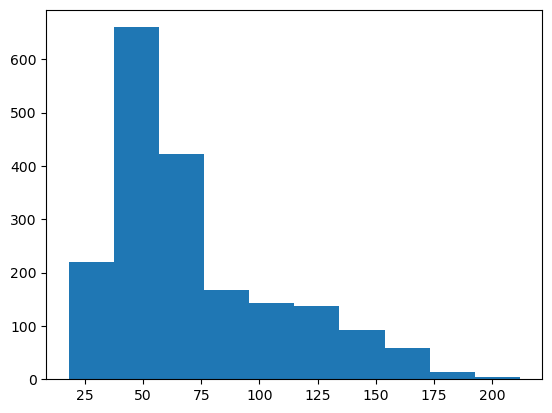

max of code text length: 212


In [2]:
# start load data
time_start = time.time()

CWE = 'CWE23'
path0 = r'D:\Desktop\hybrid-SVD\datasrc\{}\{}_bad\dsm_extract\\'.format(CWE, CWE)
path1 = r'D:\Desktop\hybrid-SVD\datasrc\{}\{}_good\dsm_extract\\'.format(CWE, CWE)

dataset = gendata(path0, CWE)
dataset += gendata(path1, CWE)
random.shuffle(dataset)

len_dataset = len(dataset)

time_fin = time.time()
print("load data time span:", time_fin - time_start)

data_len = []
for data in dataset:
    data_len.append(len(data['x']))
plt.hist(data_len)
plt.show()
print("max of code text length:", max(data_len))

In [3]:
size = [175, 45]  # instruction vec size = 45. 175 from the histogram
class MyDataset(Dataset):
    def __init__(self, dataset_, size_ = size):
        for idx, data_ in enumerate(dataset_):
            data_len_ = len(data_['x'])
            if data_len_ < size_[0]:
                pad = torch.zeros(size[0] - data_len_, size[1])
                dataset_[idx]['x'] = torch.cat((data_['x'], pad), dim=0)
            else:
                dataset_[idx]['x'] = data_['x'][:size_[0]]
        self.dateset = dataset_
        self.size = size_

    def __len__(self):
        return len(self.dateset)

    def __getitem__(self, idx):
        return self.dateset[idx]['x'], self.dateset[idx]['y']

In [4]:
# train\test\validate set

len_train = int(0.7 * len_dataset)
len_test = int(0.2 * len_dataset)
len_validate = len_dataset - len_train - len_test

Train_set = MyDataset(dataset[:len_train])
Test_set = MyDataset(dataset[len_train: len_train + len_test])
Validate_set = MyDataset(dataset[len_train + len_test:])

train_loader = DataLoader(Train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(Test_set, batch_size=32, shuffle=True)
validate_loader = DataLoader(Validate_set, batch_size=32, shuffle=True)

print(f"len of dataset:{len_dataset}, \
        len of train:{len_train}, \
        len of validate:{len_validate}, \
        len of test:{len_test}")

len of dataset:1920,         len of train:1344,         len of validate:192,         len of test:384


In [5]:
# TextCNN model
# input: batch * h = 175 * w = 45
# output: mlp with softmax
class TextCNN(nn.Module):
    def __init__(self):
        super(TextCNN, self).__init__()
        h_input = 175
        w_input = 45
        # Text_CNN layer
        conv_sizes = [2, 4, 6, 8, 10, 12, 16, 20]
        self.num_filter = len(conv_sizes)
        num_conv_per_size = 64
        self.cnv0 = nn.ModuleList([nn.Conv2d(1, num_conv_per_size, (cnv_size, 45)) for cnv_size in conv_sizes])
        # Attention layer
        self.max = nn.MaxPool2d(kernel_size=(num_conv_per_size, 1))
        self.avg = nn.AvgPool2d(kernel_size=(num_conv_per_size, 1))
        h_raw = [h_input - i + 1 for i in conv_sizes]  # 175 - conv_size +1
        conv_sizes1 = [math.ceil(i/2) for i in h_raw]
        self.cnv1 = nn.ModuleList([nn.Conv2d(2, 1, (cnv_size, 1), padding='same') for cnv_size in conv_sizes1])
        self.sig = nn.Sigmoid()
        # Output layer
        h_res = sum(h_raw)  # input_feature
        self.lin0 = nn.Linear(h_res, 512)
        self.lin1 = nn.Linear(512, 128)
        self.lin2 = nn.Linear(128, 64)
        self.lin3 = nn.Linear(64, 2)
        self.dropout = nn.Dropout(0.6)


    def forward(self, x):
        # text CNN
        # x = batch * h * w
        x = torch.unsqueeze(x, 1)  # batch, channel_in=1 , h, w
        x = [torch.squeeze(F.relu(conv(x)), 3) for conv in self.cnv0]  # each_filter: batch, channel_out=64, h'
        # x: num_filter * batch * num_per_filter=64 * h'

        # attention
        x = [torch.unsqueeze(i, 1) for i in x]  # num_filter * [ batch * 1 * num_per_filter=64 * h' ]

        max_ = [self.max(i) for i in x]  # num_filter * [batch * 1 * 1 * h' ]
        max_ = [torch.unsqueeze(torch.squeeze(i, 1), 3) for i in max_]  # num_filter * [batch * 1 * h' * 1]
        avg_ = [self.avg(i) for i in x]  # num_filter * [batch * 1 * 1 * h' ]
        avg_ = [torch.unsqueeze(torch.squeeze(i, 1), 3) for i in avg_]  # num_filter * [batch * 1 * h' * 1]

        attention = [torch.cat((max_[i], avg_[i]), dim=1) for i in range(0, self.num_filter)]  # num_filter * [batch * 2 * h' * 1]
        attention = [self.sig(self.cnv1[i](attention[i])) for i in range(0, self.num_filter)]  # num_filter * [batch * 1 * h' * 1]
        attention = [torch.unsqueeze(torch.squeeze(i, 3), 1) for i in attention]  # num_filter * [batch * 1 * 1 * h']

        x = [x[i] * attention[i] for i in range(0, self.num_filter)]  # num_filter * [ batch * 1 * num_per_filter=64 * h' ]
        x = [torch.squeeze(self.max(i)) for i in x]  # num_filter * [batch * h']
        x = torch.cat(x, dim=1)  # batch * Σ(h')
        x = torch.squeeze(x)
        # out
        x = F.relu(self.lin0(x))
        x = F.relu(self.lin1(x))
        x = self.dropout(x)
        x = F.relu(self.lin2(x))
        x = F.log_softmax(self.lin3(x), dim=-1)

        return x

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TextCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [7]:
def train():
    model.train()
    loss_all = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        labels = torch.squeeze(labels.view(1, -1))
        inputs = inputs.to(device)
        labels = labels.to(device)
        y_pred = model(inputs)
        loss = F.nll_loss(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_all += loss.item() * len(inputs)
    return loss_all / len(train_loader.dataset)

In [8]:
def test(loader):
    model.eval()
    correct = 0
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    pred_good = 0
    pred_bad = 0
    for data in loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = torch.squeeze(labels.view(1, -1))
        labels = labels.to(device)
        y_pred = model(inputs).max(dim=1)[1]
        correct += y_pred.eq(labels).sum().item() ################################
        for i in range(len(y_pred)):
            if y_pred[i] == 0 and labels[i] == 0:
                tp += 1
                pred_bad += 1
            elif y_pred[i] == 0 and labels[i] == 1:
                fp += 1
                pred_bad += 1
            elif y_pred[i] == 1 and labels[i] == 0:
                fn += 1
                pred_good += 1
            elif y_pred[i] == 1 and labels[i] == 1:
                tn += 1
                pred_good += 1
    acc = (correct / len(loader.dataset))
    return round(acc, 6), tp, fp, tn, fn, pred_good, pred_bad

In [9]:
# train & test
time_start = time.time()

train_loss_a = np.zeros(200)
test_acc_a = np.zeros(200)
for epoch in range(0,200):
    loss = train()
    train_acc, tp_, fp_, tn_, fn_, pred_good_, pred_bad_ = test(train_loader)
    test_acc, tp_, fp_, tn_, fn_, pred_good_, pred_bad_ = test(test_loader)
    train_loss_a[epoch] = loss
    test_acc_a[epoch] = test_acc
    print('Epoch: {:03d}, Loss: {:.5f},Test Acc: {:.5f}'.
          format(epoch, loss, test_acc, ))
    print('Test: TP: {:04d}, FP: {:04d}, TN: {:04d}, FN: {:04d}, Pred_good: {:04d}, Pred_bad: {:04d}'.
          format(tp_, fp_, tn_, fn_, pred_good_, pred_bad_))

print("train & test time span:", time.time() - time_start)


D:\Develop\Miniconda\envs\pytorch\lib\site-packages\torch\nn\modules\conv.py:453: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Convolution.cpp:883.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch: 000, Loss: 0.46430,Test Acc: 0.90885
Test: TP: 0156, FP: 0001, TN: 0193, FN: 0034, Pred_good: 0227, Pred_bad: 0157
Epoch: 001, Loss: 0.15980,Test Acc: 0.92188
Test: TP: 0166, FP: 0006, TN: 0188, FN: 0024, Pred_good: 0212, Pred_bad: 0172
Epoch: 002, Loss: 0.13366,Test Acc: 0.92188
Test: TP: 0183, FP: 0023, TN: 0171, FN: 0007, Pred_good: 0178, Pred_bad: 0206
Epoch: 003, Loss: 0.12375,Test Acc: 0.94010
Test: TP: 0168, FP: 0001, TN: 0193, FN: 0022, Pred_good: 0215, Pred_bad: 0169
Epoch: 004, Loss: 0.12107,Test Acc: 0.93229
Test: TP: 0166, FP: 0002, TN: 0192, FN: 0024, Pred_good: 0216, Pred_bad: 0168
Epoch: 005, Loss: 0.12026,Test Acc: 0.93490
Test: TP: 0180, FP: 0015, TN: 0179, FN: 0010, Pred_good: 0189, Pred_bad: 0195
Epoch: 006, Loss: 0.11707,Test Acc: 0.93490
Test: TP: 0190, FP: 0025, TN: 0169, FN: 0000, Pred_good: 0169, Pred_bad: 0215
Epoch: 007, Loss: 0.11468,Test Acc: 0.91927
Test: TP: 0161, FP: 0002, TN: 0192, FN: 0029, Pred_good: 0221, Pred_bad: 0163
Epoch: 008, Loss: 0.1121